# Homework07

Exercises to practice pandas, data analysis and classification

## Goals

- Understand the effects of pre-processing data
- Get familiar with the ML flow: encode -> normalize -> train -> evaluate
- Understand the difference between regression and classification tasks
- Build an intuition for different classification models

### Setup

Run the following 2 cells to import all necessary libraries and helpers for this homework.

In [1]:
!wget -q https://github.com/PSAM-5020-2025S-A/5020-utils/raw/main/src/data_utils.py
!wget -q https://github.com/PSAM-5020-2025S-A/5020-utils/raw/main/src/image_utils.py

!wget -qO- https://github.com/PSAM-5020-2025S-A/5020-utils/releases/latest/download/0801-500.tar.gz | tar xz

In [2]:
import pandas as pd
import PIL.Image as PImage

from os import listdir, path

from data_utils import RandomForestClassifier, SVC
from data_utils import classification_error, display_confusion_matrix, regression_error

from image_utils import get_pixels, make_image

from Homework07_utils import CamUtils

## Classification

The dataset we are going to use has images from $25$ different security cameras, and our task is to separate them by camera. Some of the cameras move, some of them don't, and there are more than $1000$ images, so there's no way we want to do this by hand.

### Loading Data

If we look at the images in `./data/image/0801-500/train/`, we'll notice that they are named and organized in a very particular way. They're all in the same directory and the first part of their filename specifies which camera they came from. Even though those `ids` are numbers, they're not sequential, so we'll use some helper functions to extract a unique `label` from their filenames.

This is exactly what the `OrdinalEncoder` class does, but since we only have to encode this one column, we'll do it by hand while we read the files in.

In [3]:
# this creates a list of all the files in a given directory, that end in .jpg
train_files = [f for f in listdir("./data/image/0801-500/train") if f.endswith(".jpg")]

In [6]:
# TODO: check and see what is inside the list here
print(train_files)

['01-07.jpg', '01-17.jpg', '01-19.jpg', '01-30.jpg', '01-32.jpg', '01-33.jpg', '01-38.jpg', '01-39.jpg', '01-40.jpg', '01-46.jpg', '02-06.jpg', '02-14.jpg', '02-21.jpg', '02-24.jpg', '02-30.jpg', '02-31.jpg', '02-36.jpg', '02-40.jpg', '02-47.jpg', '02-48.jpg', '03-05.jpg', '03-13.jpg', '03-20.jpg', '03-23.jpg', '03-35.jpg', '03-36.jpg', '03-67.jpg', '03-69.jpg', '03-78.jpg', '03-79.jpg', '05-02.jpg', '05-15.jpg', '05-21.jpg', '05-22.jpg', '05-25.jpg', '05-29.jpg', '05-30.jpg', '05-40.jpg', '05-42.jpg', '05-49.jpg', '06-15.jpg', '06-17.jpg', '06-30.jpg', '06-32.jpg', '06-36.jpg', '06-37.jpg', '06-47.jpg', '06-53.jpg', '06-63.jpg', '06-75.jpg', '07-01.jpg', '07-09.jpg', '07-11.jpg', '07-12.jpg', '07-15.jpg', '07-31.jpg', '07-42.jpg', '07-48.jpg', '07-75.jpg', '07-85.jpg', '08-00.jpg', '08-19.jpg', '08-21.jpg', '08-22.jpg', '08-27.jpg', '08-35.jpg', '08-48.jpg', '08-50.jpg', '08-52.jpg', '08-53.jpg', '09-04.jpg', '09-06.jpg', '09-30.jpg', '09-38.jpg', '09-41.jpg', '09-48.jpg', '09-62.jpg'

Now we'll read the image pixels and extract their labels. `CamUtils.get_label()` is the helper function we'll use to "encode" and return a label id based on the filename.

In [ ]:
pixel_data = []
label_data = []


for fname in train_files:
  label = CamUtils.get_label(fname) 
  img = PImage.open(path.join("./data/image/0801-500/train", fname)) #in this instance the path and fname results in the full path to the image, where fname is the name of the image
  pixel_data.append(get_pixels(img))
  label_data.append(label)

In [12]:
# TODO: check if labels got extracted correctly by looking at 
#       the first few items of the label list and the filename list

print(train_files[-10:])
print(label_data[-10:])

['31-02.jpg', '31-05.jpg', '31-06.jpg', '31-08.jpg', '31-11.jpg', '31-13.jpg', '31-15.jpg', '31-19.jpg', '31-20.jpg', '31-21.jpg']
[24, 24, 24, 24, 24, 24, 24, 24, 24, 24]


The labels and the filenames won't match exactly since labels start at $0$ and the filenames start at $01$ and skip some numbers.

We can open some images from pixels, just to make sure we loaded them correctly:

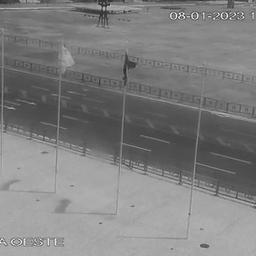

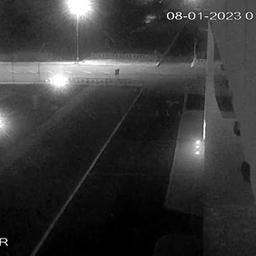

In [13]:
display(make_image(pixel_data[0]))
display(make_image(pixel_data[10]))

And now might not be a bad time to peek into the `data/image/0801-500/` directories to see what's inside them and what the images look like.... and get to know the data...

### DataFrame it

Let's put our raw pixel data into a `DataFrame`, and create a column for storing each image's label.

(this next cell might take a while to run)

In [ ]:
train_df = pd.DataFrame(pixel_data)
train_df["label"] = label_data

Let's inspect our `DataFrame`:

In [ ]:
train_df.head()

### Insight

<span style="color:hotpink">
Does anything stand out as peculiar about the feature values in our <code>DataFrame</code>?<br>
Do we have to encode or scale our data?<br>
Why? Or, why not?<br>
</span>

<span style="color:hotpink;">EDIT THIS CELL WITH ANSWER</span>

### Test Files

If that worked, repeat the process for the test files inside the `./data/image/0801-500/test/` directory.

We can almost use the exact same steps as we did above to create a `DataFrame`, the only difference being that we don't have labels for these images.

In [ ]:
# TODO: create a list of files in the test/ directory
test_files = []

# TODO: check its length and content

test_pixel_data = []

# TODO: loop over files and load their pixels into a list

# TODO: load into DataFrame (this might take 20 - 30 seconds)

Check the `DataFrame`

In [ ]:
test_df.head()

Looks like data!!

We could train a `RandomForestClassifier` directly on this `DataFrame` and see what would happen, but my guess is that Python runs out of memory and crashes our tab/browser/computer...

We'll use _projection_ to reduce the number of dimensions in our dataset. Projection is when we just drop some of the columns in our dataset. 

Which columns ? That's up to us.

Let's first try using the first $N$ columns/features where $N$ is a number around $10$.

This is how we get the first $N$ columns from a `DataFrame`:

In [ ]:
# split input and output features
NUM_FEATURES = 10
chosen_columns = train_df.columns[:NUM_FEATURES]
train_features = train_df[chosen_columns]

out_features = train_df["label"]

# also separate test dataset features
test_features = test_df[chosen_columns]

From our [Week 07](https://github.com/PSAM-5020-2025S-A/WK07) notebook, we can create a classification model by following these steps:

1. Load dataset (done! 🎉)
2. Encode label features as numbers (not needed! done! ⚡️)
3. Normalize the data (not needed! done! 🍾)
4. Separate the outcome variable and the input features (done! ☀️)
5. Create a model using chosen features
6. Run model on training data and measure error*
7. Run model on test data, measure error*, plot predictions, interpret results

We could use the same `regression_error()` function we used above to measure the error of our classifier model, but this could lead to $2$ issues. First, we don't have labels for the images in the test dataset, and second, the regression error reported might be higher than it actually is because an image with label $0$ that gets mislabeled as $5$ will count as being more wrong than if it was mislabeled $2$. And we don't want that. We just want to get the percentage of classifications that our model gets correctly.

To simplify calculating the classification accuracy we can use the `CamUtils.classification_accuracy()` function. This function takes $2$ parameters, a list of files and a list of predictions. It will work with the test and train datasets and will calculate a more meaningful accuracy value than the one returned by `regression_error()`.

In [ ]:
# TODO: create a brand new classifier
# TODO: fit the model
# TODO: run predictions
# TODO: measure classification accuracy
CamUtils.classification_accuracy(train_files, train_predictions)

That should look promising. Let's run this on our test dataset.

Remember we already separated the test data features into a variable called `test_features` above.

Now we just have to run the prediction and measure accuracy.

In [ ]:
# TODO: run predictions on test data
# TODO: measure classification accuracy

### Interpretation

Using just the first $10$ pixels of the image the classifier is able to label most of the images correctly.

<span style="color:hotpink">
How can we improve this classifier? How does the number of features affect the classification accuracy of the test data<br>
How does the choice of pixels affect the accuracy?<br><br>
If you're curious, repeat the modeling above, but using the <code>SVC</code> classifier instead of <code>RandomForest</code>.<br>How does the choice of modeling technique affect the accuracy?<br><br>
Experiment with some of these parameters and explain your findings below.
</span>

<span style="color:hotpink;">EDIT THIS CELL WITH ANSWER</span>